In [1]:
import numpy as np
import pandas as pd
import os
pd.set_option('display.max_columns',None)
import seaborn as sns
from collections import defaultdict

def basic_summary(df):
    
    '''
    Report the basic information about the input dataframe
    
    Args:
    df -> pd.DataFrame
    
    Returns:
    None
    '''
    
    print(f"Samples : {df.shape[0]:,} \nColumns : {df.shape[1]} : {list(df.columns.values)}")
    print("\nHeads")
    display(df.head(3))
    print("\nData types")
    display(pd.DataFrame(df.dtypes, columns=['dtypes']).transpose())
    print("\nNull values")
    display(pd.concat([df.isna().sum(),df.isna().mean() * 100],axis=1).rename({0:'count',1:'pct'},axis=1).transpose())
    print("\nBasic statistics")
    display(df.describe().transpose())
      

if __name__ == "__main__":
    
    BASE_PATH = '/kaggle/input/anime-recommendations-database/'
    ANIME_DTYPES = {'anime_id': str, 'name': str, 'genre': str, 'type': str, 'episodes': str, 'rating': float, 'members': int}
    RATING_DTYPES = {'user_id': str, 'anime_id': str, 'rating': int}
    ANIME_PATH = os.path.join(BASE_PATH, 'anime.csv')
    RATING_PATH = os.path.join(BASE_PATH, 'rating.csv')

    anime = pd.read_csv(ANIME_PATH, dtype = ANIME_DTYPES)
    rating = pd.read_csv(RATING_PATH,  dtype = RATING_DTYPES)

# Basic summary

## Anime

- The `anime` dataframe contains the data related to the anime. 

### Metadata

- anime_id - myanimelist.net's unique id identifying an anime.
- name - full name of anime.
- genre - comma separated list of genres for this anime.
- type - movie, TV, OVA, etc.
- episodes - how many episodes in this show. (1 if movie).
- rating - average rating out of 10 for this anime.
- members - number of community members that are in this anime's "group".

In [2]:
basic_summary(anime)

Samples : 12,294 
Columns : 7 : ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']

Heads


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262



Data types


,anime_id,name,genre,type,episodes,rating,members
dtypes,object,object,object,object,object,float64,int64



Null values


,anime_id,name,genre,type,episodes,rating,members
count,0.0,0.0,62.000000,25.000000,0.0,230.000000,0.0
pct,0.0,0.0,0.504311,0.203351,0.0,1.870831,0.0



Basic statistics


,count,mean,std,min,25%,50%,75%,max
rating,12064.0,6.473902,1.026746,1.67,5.88,6.57,7.18,10.0
members,12294.0,18071.338864,54820.676925,5.00,225.00,1550.00,9437.00,1013917.0


# Rating

- The `rating` dataframe contains raw data of how each user rate each anime.
- The rating score is in range [0,10]

### Metadata

- user_id - non identifiable randomly generated user id.
- anime_id - the anime that this user has rated.
- rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [3]:
basic_summary(rating)

Samples : 7,813,737 
Columns : 3 : ['user_id', 'anime_id', 'rating']

Heads


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1



Data types


,user_id,anime_id,rating
dtypes,object,object,int64



Null values


,user_id,anime_id,rating
count,0.0,0.0,0.0
pct,0.0,0.0,0.0



Basic statistics


,count,mean,std,min,25%,50%,75%,max
rating,7813737.0,6.14403,3.7278,-1.0,6.0,7.0,9.0,10.0


# Popular based recommendation

Regarding the IMDB syetem, there have a metrics called "weighted rating system" that is used to score the rating of each movie.

weighted rating 
```
(WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 
```
where:
- R = average rating for the movie. (rating)
- v = number of votes for the movie. (members)
- m = minimum votes required to be listed in the Top 250 (defined by > percentile 80 of total votes)
- C = the average rating across the whole dataset.

In [4]:
def weighted_rating(v,m,R,C):
    '''
    Calculate the weighted rating
    
    Args:
    v -> average rating for each anime (float)
    m -> minimum votes required to be classified as popular (float)
    R -> average rating for the anime (pd.Series)
    C -> average rating for the whole dataset (pd.Series)
    
    Returns:
    pd.Series
    '''
    return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )

def assign_popular_based_score(rating):
    '''
    Assigned popular based score based on the IMDB weighted average.
    
    Args:
    rating -> pd.DataFrame contains ['anime_id', 'rating'] for each user.
    
    Returns
    popular_anime -> pd.DataFrame contains anime name and IMDB weighted score.
    '''
    
    # pre processing
    filter_rating = rating[rating['rating'] != -1]
    vote_count = filter_rating.groupby('anime_id',as_index=False).agg({'user_id':'count', 'rating':'mean'})
    vote_count.columns = ['anime_id','vote_count', 'avg_rating']
    
    # calcuate input parameters
    C = np.mean(vote_count['avg_rating'])
    m = np.percentile(vote_count['vote_count'], 70)
    vote_count = vote_count[vote_count['vote_count'] >= m]
    R = vote_count['avg_rating']
    v = vote_count['vote_count']
    vote_count['weighted_rating'] = weighted_rating(v,m,R,C)
    
    # post processing
    vote_count = vote_count.merge(anime[['anime_id','name']],on=['anime_id'],how='left')
    vote_count = vote_count.drop('anime_id', axis=1)
    popular_anime = vote_count.loc[:,['name', 'vote_count', 'avg_rating', 'weighted_rating']]
    
    return popular_anime

In [5]:
popular_anime = assign_popular_based_score(rating)

# Popularity based on the number of votes count

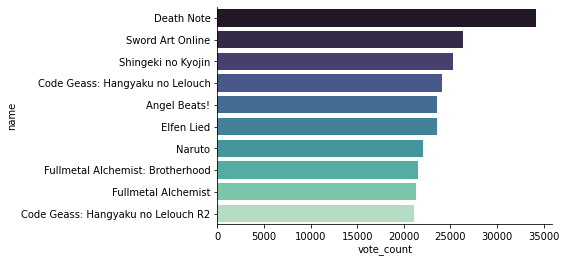

In [6]:
sns.barplot(data = popular_anime.sort_values('vote_count',ascending=False).head(10),
            x = 'vote_count', y = 'name', palette='mako');
sns.despine()

## Popularity based on the weighted score

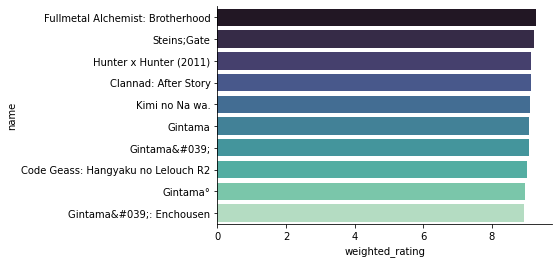

In [7]:
sns.barplot(data = popular_anime.sort_values('weighted_rating',ascending=False).head(10),
            x = 'weighted_rating', y = 'name', palette = 'mako');
sns.despine()

## Actions

1. For new users, if we don't have any information about them we can provide the list based on ranking the `vote_count` or `weighted_rating` as a best guess.

# Collaborative filtering

the implementation is inspired by : https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/ <br>
for brief summary : https://towardsdatascience.com/intro-to-recommender-system-collaborative-filtering-64a238194a26

In [8]:
collab_rating = rating.copy()
collab_rating['rating'] = collab_rating['rating'].replace(-1, 0)

n_users = collab_rating['user_id'].nunique()
n_animes = collab_rating['anime_id'].nunique()
print(f"Unique users : {n_users:,} \nUnique anime : {n_animes:,}")

Unique users : 73,515 
Unique anime : 11,200


In [9]:
# create ordered user_id, and anime_id
map_user_id = {v:int(i) for i,v in enumerate(sorted(collab_rating['user_id'].unique()))}
map_anime_id = {v:int(i) for i,v in enumerate(sorted(collab_rating['anime_id'].unique()))}

collab_rating['csr_user_id'] = collab_rating['user_id'].map(map_user_id)
collab_rating['csr_anime_id'] = collab_rating['anime_id'].map(map_anime_id)
collab_rating = collab_rating.merge(anime[['anime_id', 'name']], on='anime_id', how='left')
map_csr_anime_id_to_name = {ind:name for ind, name in zip(collab_rating['csr_anime_id'], collab_rating['name'])}
map_name_to_csr_anime_id = {name:ind for ind, name in map_csr_anime_id_to_name.items()}

In [10]:
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm

row = collab_rating['csr_user_id']
col = collab_rating['csr_anime_id']
data = collab_rating['rating']

mat = csr_matrix((data, (row, col)), shape=(n_users, n_animes))
mat.eliminate_zeros()

sparsity = float(len(mat.nonzero()[0]))
sparsity /= (mat.shape[0] * mat.shape[1])
sparsity *= 100
print(f'Sparsity: {sparsity:4.2f}%. This means that {sparsity:4.2f}% of the user-item ratings have a value.')

Sparsity: 0.77%. This means that 0.77% of the user-item ratings have a value.


In [11]:
def train_test_split(mat, test_size = 0.2):
    
    train = mat.copy()
    
    test_row = []
    test_col = []
    test_data = []
    
    for user in tqdm(range(mat.shape[0])):
        
        user_ratings = mat[user, :].nonzero()[1] # extract the csr_anime_id that has a rating > 0
        test_ratings = np.random.choice(user_ratings,
                                        size = int(test_size * len(user_ratings)), # random test label based on each user_ratings size.
                                        replace = False)
        
        # because the changing the csr_matrix is expensive, we store the data and create new csr_matrix instead.
        test_row.extend([user] * len(test_ratings))
        test_col.extend(list(test_ratings))
        test_data.extend(list(train[user, test_ratings].toarray()[0]))
        
        train[user, test_ratings] = 0
    
    test = csr_matrix((test_data, (test_row, test_col)), shape=(mat.shape[0], mat.shape[1]))
    test.eliminate_zeros()
    
    return train, test

In [12]:
train, test = train_test_split(mat)

  0%|          | 0/73515 [00:00<?, ?it/s]



## Dimensionality Reduction

Due to the size of user-item matrix. It's difficult to compute the user_features with `n_users x n_users` shape or the anime_features with `n_animes x n_animes` shape. <br>
Thus, we use the `TruncatedSVD` as a dimensionality reduction tool.

### TruncatedSVD

> Truncated SVD shares similarity with PCA while SVD is produced from the data matrix and the factorization of PCA is generated from the covariance matrix. Unlike regular SVDs, truncated SVD produces a factorization where the number of columns can be specified for a number of truncation. (https://towardsdatascience.com/recommender-system-singular-value-decomposition-svd-truncated-svd-97096338f361)


In [13]:
from sklearn.decomposition import TruncatedSVD

epsilon = 1e-9

anime_svd = TruncatedSVD(n_components=10)
anime_features = anime_svd.fit_transform(train.transpose()) + epsilon

user_svd = TruncatedSVD(n_components=10)
user_features = user_svd.fit_transform(train) + epsilon

print(f"anime_features shape : {anime_features.shape}\nuser_feature shape : {user_features.shape}")

anime_features shape : (11200, 10)
user_feature shape : (73515, 10)


In [14]:
def top_k_similar_anime(anime_id, top_k, corr_mat, map_name):
    
    # sort correlation value ascendingly and select top_k csr_anime_id
    top_anime = corr_mat[anime_id,:].argsort()[-top_k:][::-1] 
    
    # convert csr_anime_id to anime name
    top_anime = [map_name[e] for e in top_anime] 

    return top_anime

## Memory based approache

There are 2 types of memory based collaborative filtering
1. User based - The user-similarity matrix will consist of some distance metric that measures the similarity between any two pairs of users. 
2. Item based - Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

> The key difference of memory-based approach from the model-based techniques is that we are **not learning any parameter** using gradient descent (or any other optimization algorithm). <br> The closest user or items are calculated only by using **Cosine similarity** or **Pearson correlation coefficients**, which are only based on arithmetic operations. (https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0)

We calculate the pearson correlation between each anime and check up for the top_k most similar anime to recommend. 

**Drawback**
1. It's not scalable.

### Pearson correlation

In [15]:
corr_mat = np.corrcoef(anime_features)

In [16]:
similar_anime = top_k_similar_anime(map_name_to_csr_anime_id['Naruto'],
                                    top_k = 10,
                                    corr_mat = corr_mat,
                                    map_name = map_csr_anime_id_to_name)
similar_anime

['Naruto',
 'Bleach',
 'Dragon Ball Kai',
 'Shaman King',
 'Konjiki no Gash Bell!!',
 'Toriko',
 'Densetsu no Yuusha Da Garn',
 'Katekyo Hitman Reborn!',
 'Beelzebub',
 'Bleach Movie 4: Jigoku-hen']

In [17]:
similar_anime = top_k_similar_anime(map_name_to_csr_anime_id['Death Note'],
                                    top_k = 10,
                                    corr_mat = corr_mat,
                                    map_name = map_csr_anime_id_to_name)
similar_anime

['Death Note',
 'Hellsing Ultimate',
 'Soul Eater',
 'Fullmetal Alchemist: Brotherhood',
 'Deadman Wonderland',
 'Afro Samurai Movie',
 'Black Lagoon: Roberta&#039;s Blood Trail',
 'Highschool of the Dead',
 'Code Geass: Hangyaku no Lelouch',
 'Berserk: Ougon Jidai-hen II - Doldrey Kouryaku']

### Cosine similarity

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_mat = cosine_similarity(anime_features)

In [19]:
similar_anime = top_k_similar_anime(map_name_to_csr_anime_id['Naruto'],
                                    top_k = 10,
                                    corr_mat = cosine_mat,
                                    map_name = map_csr_anime_id_to_name)
similar_anime

['Naruto',
 'Shaman King',
 'Bleach',
 'Soul Eater',
 'Fullmetal Alchemist',
 'Dragon Ball Z',
 'Dragon Ball',
 'Death Note',
 'Fullmetal Alchemist: Brotherhood',
 'Dragon Ball GT']

In [20]:
similar_anime = top_k_similar_anime(map_name_to_csr_anime_id['Death Note'],
                                    top_k = 10,
                                    corr_mat = cosine_mat,
                                    map_name = map_csr_anime_id_to_name)
similar_anime

['Death Note',
 'Soul Eater',
 'Fullmetal Alchemist',
 'Elfen Lied',
 'Code Geass: Hangyaku no Lelouch',
 'Fullmetal Alchemist: Brotherhood',
 'Code Geass: Hangyaku no Lelouch R2',
 'Naruto',
 'Shingeki no Kyojin',
 'Angel Beats!']

## Model-based approach

There are 3 types of model-based approach
1. Non parametric based
    - KNN (Surprise)
2. Matrix Factorization based
    - SVD (Surprise)
    - Probabilistic Matrix Factorization (fastai)
    - Non-ve Matrix Factorization (Surprise)
3. Deep learning based
    - Embedding layer (fastai)

## Matrix factorization - SVD

In [21]:
from surprise import SVD, accuracy
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection.split import train_test_split

def pred2dict(predictions, top_k=None):
    
    rec_dict = defaultdict(list)
    for user_id, anime_id, actual_rating, pred_rating, _ in tqdm(predictions):
        rec_dict[user_id].append((anime_id, pred_rating))        
        
    return rec_dict

def get_top_k_recommendation(rec_dict, user_id, top_k, animeid2name):
    
    pred_ratings = rec_dict[user_id]
    pred_ratings = sorted(pred_ratings, key=lambda x: x[1], reverse=True) # sort descendingly by pred_rating
    pred_ratings = pred_ratings[:top_k]
    recs = [animeid2name[e[0]] for e in pred_ratings]
    
    return recs

reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(collab_rating[['user_id','anime_id','rating']], reader)
train, test = train_test_split(data, test_size=.2, random_state=42)

algo = SVD()
algo.fit(train)
pred = algo.test(test)
accuracy.rmse(pred)

RMSE: 1.9521


1.952126331889687

### Prediction - SVD

In [22]:
collab_rating[ (collab_rating['user_id'] == '3') & (collab_rating['rating'] > 0)].sort_values('rating',ascending=False).head(10)

,user_id,anime_id,rating,csr_user_id,csr_anime_id,name
221,3,20159,10,22222,3247,Pokemon: The Origin
173,3,1535,10,22222,1768,Death Note
195,3,9989,10,22222,11192,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...
212,3,16894,10,22222,2227,Kuroko no Basket 2nd Season
203,3,11771,10,22222,784,Kuroko no Basket
216,3,18115,10,22222,2621,Magi: The Kingdom of Magic
240,3,28171,10,22222,5562,Shokugeki no Souma
165,3,813,10,22222,10229,Dragon Ball Z
209,3,16498,10,22222,2084,Shingeki no Kyojin
208,3,14513,10,22222,1574,Magi: The Labyrinth of Magic


In [23]:
animeid2name = {ind:name for ind,name in zip(collab_rating['anime_id'], collab_rating['name'])}

rec_dict = pred2dict(pred)
recs = get_top_k_recommendation(rec_dict, '3', 10, animeid2name)
recs

  0%|          | 0/1562748 [00:00<?, ?it/s]

['Shingeki no Kyojin',
 'Tokyo Ghoul',
 'Fate/stay night: Unlimited Blade Works',
 'Inazuma Eleven',
 'Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka',
 'Haikyuu!! Second Season',
 'Soul Eater',
 'Ao no Exorcist Movie',
 'DRAMAtical Murder',
 'Akame ga Kill!']